In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

In [3]:
tokenizer=AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model=AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


In [4]:
tokens=tokenizer.encode("Meh, it was okay!",return_tensors='pt')

In [5]:
result=model(tokens)

In [6]:
result.logits

tensor([[-1.1413,  1.5708,  3.0444, -0.0682, -2.8842]],
       grad_fn=<AddmmBackward0>)

In [7]:
int(torch.argmax(result.logits))+1

3

In [8]:
r=requests.get("https://www.yelp.com/biz/wayfare-tavern-san-francisco-2")
soup=BeautifulSoup(r.text,'html.parser')
regex=re.compile('.*comment.*')
results=soup.find_all('p',{'class':regex})
reviews=[result.text for result in results]

In [9]:
reviews[0]

"Very Londonesque charm outside.Since we arrived early for our reservations, we sat at the bar while waiting for our table. Beautiful ambiance all around. Bar service wasn't great but we didn't allow that deter us. Once we were moved to our cozy table, everything was wonderful. The bread, the entrees, the service ...This was a perfect choice to celebrate my honey. I will surely return."

In [10]:
df=pd.DataFrame(np.array(reviews),columns=['review'])

In [12]:
df['review'].iloc[0]

"Very Londonesque charm outside.Since we arrived early for our reservations, we sat at the bar while waiting for our table. Beautiful ambiance all around. Bar service wasn't great but we didn't allow that deter us. Once we were moved to our cozy table, everything was wonderful. The bread, the entrees, the service ...This was a perfect choice to celebrate my honey. I will surely return."

In [13]:
def sentiment_score(review):
    tokens=tokenizer.encode(review,return_tensors='pt')
    result=model(tokens)
    return int(torch.argmax(result.logits))+1

In [15]:
sentiment_score(df['review'].iloc[1])

5

In [16]:
df['sentiment']=df['review'].apply(lambda x: sentiment_score(x[:512]))

In [17]:
df

,review,sentiment
0,Very Londonesque charm outside.Since we arrive...,4
1,Never a dull moment when dining at Wayfare.The...,5
2,"Way to turn it around, Wayfare Tavern!I return...",4
3,The hostess this Saturday evening needs to tak...,2
4,Went here to celebrate my buddy's recent birth...,5
5,Food: Bread (Popovers): Excellent. Freshly bak...,4
6,"On a recommendation from some friends I trust,...",5
7,The service has always been quick and friendly...,5
8,I've had Wayfare Tavern bookmarked for some ti...,5
9,Wayfare Tavern is a secretly tucked away resta...,4


In [18]:
# Function to categorize sentiment
def categorize_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply categorization to sentiment scores
df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

# Display the updated DataFrame
df.head()


,review,sentiment,sentiment_category
0,Very Londonesque charm outside.Since we arrive...,4,Positive
1,Never a dull moment when dining at Wayfare.The...,5,Positive
2,"Way to turn it around, Wayfare Tavern!I return...",4,Positive
3,The hostess this Saturday evening needs to tak...,2,Negative
4,Went here to celebrate my buddy's recent birth...,5,Positive


In [27]:
# Keywords for aspects
aspect_keywords = {
    'food': ['food', 'dish', 'meal', 'menu'],
    'service': ['service', 'waiter', 'staff', 'server'],
    'ambiance': ['ambiance', 'environment', 'atmosphere', 'decor']
}

# Function to analyze aspects in reviews
def analyze_aspects(review):
    aspects = {}
    for aspect, keywords in aspect_keywords.items():
        # Check if any keyword related to the aspect is in the review
        if any(keyword in review.lower() for keyword in keywords):
            # Pass the review string directly to sentiment_score
            aspects[aspect] = sentiment_score(review)  # Pass the review directly
    return aspects

# Apply aspect analysis to the reviews in the DataFrame
df['aspect_sentiment'] = df['review'].apply(analyze_aspects)


# Display the updated DataFrame
df


,review,sentiment,sentiment_category,aspect_sentiment
0,Very Londonesque charm outside.Since we arrive...,4,Positive,"{'service': 4, 'ambiance': 4}"
1,Never a dull moment when dining at Wayfare.The...,5,Positive,"{'food': 5, 'service': 5, 'ambiance': 5}"
2,"Way to turn it around, Wayfare Tavern!I return...",5,Positive,"{'food': 5, 'service': 5}"
3,The hostess this Saturday evening needs to tak...,2,Negative,{}
4,Went here to celebrate my buddy's recent birth...,5,Positive,{'service': 5}
5,Food: Bread (Popovers): Excellent. Freshly bak...,3,Positive,"{'food': 3, 'service': 3, 'ambiance': 3}"
6,"On a recommendation from some friends I trust,...",5,Positive,{'service': 5}
7,The service has always been quick and friendly...,5,Positive,"{'food': 5, 'service': 5}"
8,I've had Wayfare Tavern bookmarked for some ti...,4,Positive,"{'food': 4, 'service': 4, 'ambiance': 4}"
9,Wayfare Tavern is a secretly tucked away resta...,4,Positive,"{'food': 4, 'service': 4}"


In [31]:
# Plotting sentiment distribution
fig = px.histogram(df, x='sentiment_category', title='Sentiment Distribution')
fig.show()




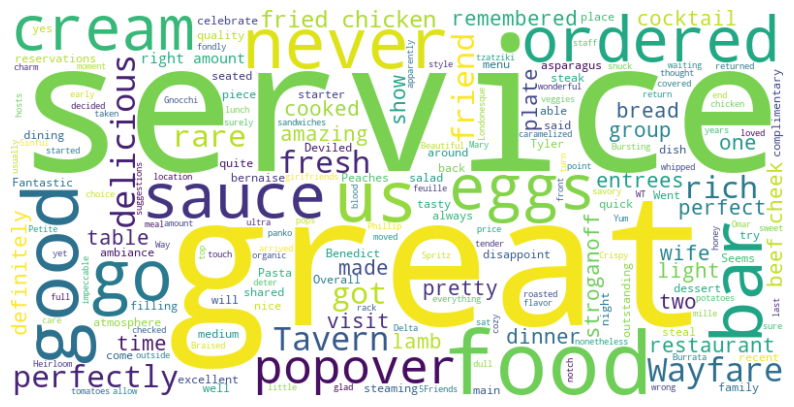

In [32]:

# Generate a word cloud for positive reviews
positive_reviews = ' '.join(df[df['sentiment_category'] == 'Positive']['review'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
